### Neighbourhood_PublicTransport

We continue with an accessibility analysis. We focus on one suburb and visualize Travel Time to nearest Public Transport. We do this cumulatively and separately. All service providers together and each service provider individually. Then we try an interactive `html` visualization.

<div class="alert alert-block alert-info"><b>NOTE:</b></div>

> I've tried to structure the notebook to be easily reproducable. It focuses on one neighborhood extracted from a larger file containing many suburbs ~ this can be wards / census tracts or even a municipality.

In [1]:
#load the magic

%matplotlib inline
import os
from pathlib import Path

import pandana as pdna
from pandana.loaders import osm

import time
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

In [2]:
#set path
path = Path('./')

In [3]:
#load suburbs directly via City Cape Town API ~ provide a general region to clip other data too
sub_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/75/query?where=1%3D1&outFields=*&outSR=4326&f=json'
sub_shp = gpd.read_file(sub_object)
sub_shp = sub_shp.set_crs(epsg=4326)

### Explore and choose with ... 

In [4]:
sub_shp['OFC_SBRB_NAME'].unique()

array(['HYDE PARK', 'SPRINGFIELD', 'NIEUW MAASTRECHT-2', 'CHARLESVILLE',
       'WILDWOOD', 'MALIBU VILLAGE', 'TUSCANY GLEN', 'VICTORIA MXENGE',
       'KHAYELITSHA', 'CASTLE ROCK', 'MANSFIELD INDUSTRIA', 'SUN VALLEY',
       'DANARAND', 'BENNO PARK', 'KLOOFZICHT', 'EENSGEVONDEN', 'OAKDENE',
       'THORNTON', 'BELHAR EXT 15', 'MONTANA EXTENSION', 'HIGHVELD',
       'HEEMSTEDE', 'SHIRLEY PARK', 'BRACKENFELL COMMON', 'JOUBERTPARK',
       'GROENVALLEI', 'SONKRING', 'SAXONWOOD', 'PROTEA PARK - WESFLEUR',
       'TRE DONNE', 'DE OUDE SPRUIT', 'PAROW GOLF COURSE', 'SUNBIRD PARK',
       'THE CONIFERS', 'WINGFIELD', 'WINDERMERE', 'BO-KAAP',
       'HELDERBERG PARK', 'GREENFIELDS', 'SPRINGBOKPARK', 'DELFT 3',
       'SILVERTOWN - KHAYELITSHA', 'EERSTERIVIER', 'GOOD HOPE',
       'PHILIPPI PARK', 'KUILSRIVIER INDUSTRIA', 'FERNDALE', 'GOODRAIL',
       'DE DUIN', 'ELSIES RIVER INDUSTRIA', 'WESTGATE',
       'KRAAIFONTEIN EAST', 'TURTLE CREEK', 'ZEVENWACHT MALL', 'KAAPSIG',
       'LANGA', 'SUN

In [5]:
# extract only the area of interest and set as mask ~ change WOODSTOCK 
woodstock_shp = sub_shp.loc[sub_shp['OFC_SBRB_NAME'].isin(['WOODSTOCK'])].copy()
mask = woodstock_shp

In [6]:
# I want major routes for context ~ large dataset are challenging to load via API; loaded locally
str_object = path/'data/TCT_Road_Centreline.shp'
str_shp = gpd.read_file(str_object, mask=mask)
str_shp = str_shp.set_crs(epsg=4326)

# I know what major roads I want
main = str_shp[str_shp['ROAD_NAME'].isin(['FW DE KLERK', 'VICTORIA', 'ALBERT', 'NELSON MANDELA'])]

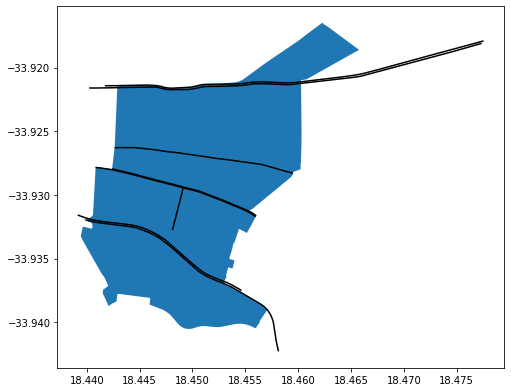

In [6]:
#plot
fig, ax = plt.subplots(figsize=(8,8))
woodstock_shp.plot(zorder=1, ax=ax)
main.plot(zorder=2, color='black', ax=ax)
plt.show()

#### If you dont have access to local data consider `osm`

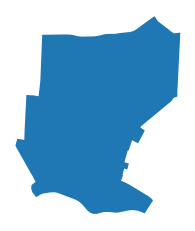

In [7]:
import osmnx as ox
# get the boundary polygon, project it, and plot it
city = ox.gdf_from_place(('Woodstock, Cape Town, South Africa'), which_result=1)
#city = ox.projection.project_gdf(city)
ax = city.plot()
_ = ax.axis('off')

In [8]:
# Get bounding box coordinates 
minx, miny, maxx, maxy = woodstock_shp.bounds.iloc[0].values
bbox = (minx, miny, maxx, maxy)
print(bbox)

(18.43943027844247, -33.94052433350784, 18.465807678713986, -33.916486084322436)


<div class="alert alert-block alert-warning"><b>ATTENTION</b></div>

>  **Public Transport** is harvested from `osm`. Some of these were already on the map, others I captured myself and amended the `operator` tag ~ hence the reason to focus on a small area where I know these features are. Its also a cool way to update `osm` - **Please adhere to the documentation and edit as per the [osm guide](https://wiki.openstreetmap.org/wiki/Beginners_Guide_1.3)**.

In [9]:
# what public transport?
public_transport = ['bus_stop', 'platform', 'station']

In [10]:
start_time = time.time()
# query the OSM API for the specified transport within the bounding box 
osm_tags = '"public_transport"~"{}"'.format('|'.join(public_transport))
pois = osm.node_query(miny, minx, maxy, maxx, tags=osm_tags)
    
#### save to CSV if you choose
#pois = pois[pois['amenity'].isin(amenities)]
#pois.to_csv(amenities_filename, index=False, encoding='utf-8')
method = 'downloaded from OSM'
    
print('{:,} public_transport {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['public_transport', 'name', 'operator', 'lat', 'lon']].head()

45 public_transport downloaded from OSM in 1.02 seconds


,public_transport,name,operator,lat,lon
id,,,,,
288676995,station,Woodstock,Metrorail,-33.925313,18.446164
288678132,station,Esplanade,Metrorail,-33.923687,18.445966
349078745,station,Salt River,Metrorail,-33.927229,18.465014
536984904,bus_stop,NaN,Golden Arrow Bus Service,-33.930396,18.453068
536984912,bus_stop,NaN,Golden Arrow Bus Service,-33.931336,18.455160


In [14]:
# who are the service operators?
pois.operator.value_counts(dropna=False)

MyCiTi                      31
Golden Arrow Bus Service    11
Metrorail                    3
Name: operator, dtype: int64

In [15]:
# what type of stops are there?
pois.public_transport.value_counts(dropna=False)

platform    31
bus_stop    11
station      3
Name: public_transport, dtype: int64

#### Convert to `GeoDataFrame` as desired

In [31]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(pois.lon, pois.lat)]
#df = df.drop(['lon', 'lat'], axis=1)
gdf = gpd.GeoDataFrame(pois, crs="EPSG:4326", geometry=geometry)

#### Load buildings

In [11]:
#load building footprints ~ large dataset are challenging to load via API; loaded locally
buil_object = path/'data/2D_Basic_Footprint.shp'

#extract only the buildings inside the area of interest ~ inside the mask 
build_shp = gpd.read_file(buil_object, mask=mask)
sub_build_shp = build_shp.set_crs(epsg=4326)

In [17]:
sub_build_shp.head(2)

,OBJECTID,ACQS_SRC,ACQS_PRD,SHAPE_Leng,SHAPE_Area,geometry
0,25880,Photogrammetry,201312,55.064287,172.657508,"POLYGON ((18.46052 -33.91840, 18.46036 -33.918..."
1,25881,Photogrammetry,201312,165.937474,598.336171,"POLYGON ((18.46249 -33.91705, 18.46238 -33.917..."


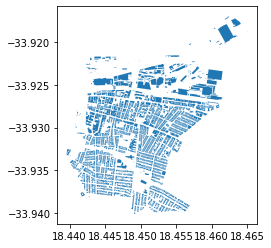

In [18]:
sub_build_shp.plot()

#### If you dont have access to local data consider `osm` 

The `geometries_from_point` and `geometries_from_place` module should be [replacing](https://github.com/gboeing/osmnx/issues/526) `buildings_from_place`,  `footprints_from_point` and `footprints_from_place` but it still executed correctly here. ~ I also changed the way  buildings where tagged; explicitly noting the suburb and city. 

In [ ]:
# get all building footprints in some neighborhood
place = 'Woodstock, Cape Town, South Africa'
gdf = ox.footprints_from_place(place)#, tags={'building':True})
gdf.shape

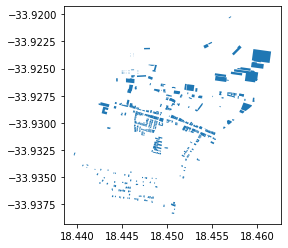

In [20]:
gdf.plot()

#### We need `x` and `y` coordinates not polygons

In [ ]:
#get x,y coords of the building centers
sub_build_shp['x'] = sub_build_shp['geometry'].centroid.x
sub_build_shp['y'] = sub_build_shp['geometry'].centroid.y

#### Load `osm` streets and build network

In [13]:
%%time
#load
net_filename = path/'data/osm2Way_network_CPT_walk.h5'

osm_walk_nodes = pd.HDFStore(net_filename).nodes
osm_walk_edges = pd.HDFStore(net_filename).edges

Wall time: 6.99 s


In [14]:
%%time
network = pdna.Network(osm_walk_nodes["x"],
                       osm_walk_nodes["y"], 
                       osm_walk_edges["from"], 
                       osm_walk_edges["to"],
                       osm_walk_edges[["distance"]],
                       twoway=True)
print('Network initialized')

Network initialized
Wall time: 12.3 s


<div class="alert alert-block alert-success"><b>Calculate and Plot access to all Public Transport</b></div>

In [15]:
#set some parameters
distance = 1200    # 15 minutes walking
num_close = 1

In [16]:
#get osm node_ids for the buildings
x, y = sub_build_shp.x, sub_build_shp.y
sub_build_shp["node_ids"] = network.get_node_ids(x, y)

In [17]:
#set the myciti stops to the osm network and calculate nearest neighbor (two)
network.set_pois("all", distance , num_close, x_col=pois['lon'], y_col=pois['lat'])
stop_walk_distances = network.nearest_pois(distance , "all", num_pois=num_close, include_poi_ids=False)

In [18]:
# Rename columns
stop_walk_distances.columns=['d_publicTrans']#, axis=1, inplace=True)

In [19]:
#match the osm node_ids and transfer distance from building to mycity stop 
sub_build_shp['d_publicTrans'] = sub_build_shp['node_ids'].map(stop_walk_distances['d_publicTrans'])

In [20]:
# add a time column
# Calculate time ~ minutes ~ based on distances    ((distance/1609)/speed)*60)
sub_build_shp['m_publicTrans'] = sub_build_shp.apply(lambda row: ((row.d_publicTrans/1609)/3)*60, axis=1)

<div class="alert alert-block alert-info"><b>PLOT</b></div>

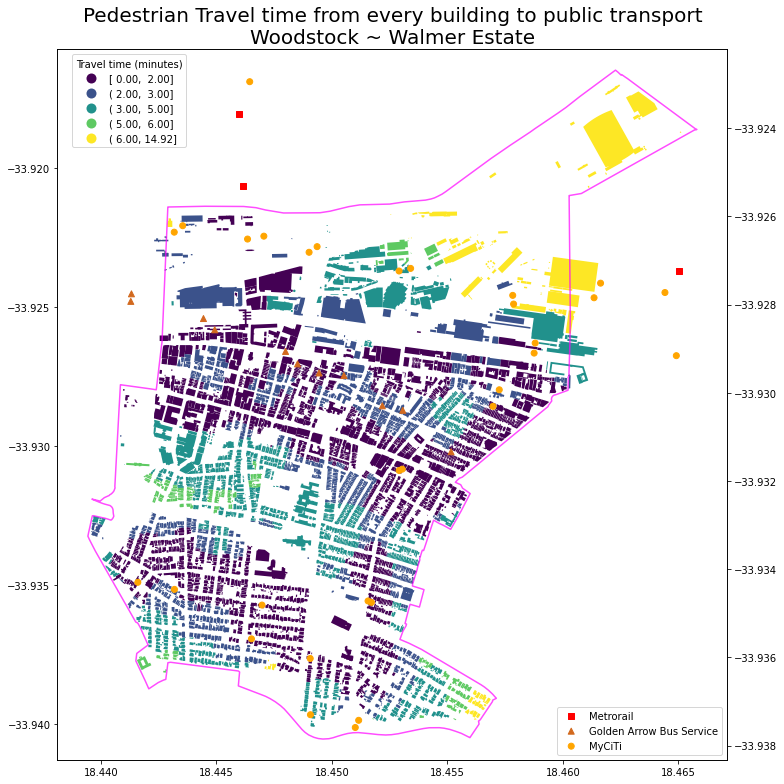

In [47]:
# plot
fig, ax = plt.subplots(figsize=(11,11))
#ax.axis([bbox[0], bbox[2], bbox[1], bbox[3]])

sub_build_shp.plot(column='m_publicTrans', 
                   scheme='user_defined', 
                   classification_kwds={'bins':[2, 3, 5, 6]},   # define your own bins as desired
                   #scheme='quantiles', 
                   legend=True, ax=ax)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 1.0))
leg.set_title("Travel time (minutes)")

colors = {'Metrorail':'red', 'Golden Arrow Bus Service':'chocolate', 'MyCiTi':'orange'}
cmap = ListedColormap(colors)
markers = {'Metrorail': 's', 'Golden Arrow Bus Service': '^', 'MyCiTi': 'o'}

ax2 = ax.twinx()
for key, values in markers.items():
    d = pois[pois.operator == key]
    ax2.scatter(x=d['lon'], y=d['lat'], zorder=0.5,
                c=d.operator.map(colors), label=key,
                marker = values)
    
# add a second legend
ax2.legend(loc=4)

#some context
woodstock_shp.boundary.plot(ax=ax, zorder=1, alpha=0.7, color='magenta')
#main.plot(zorder=2, color='grey', ax=ax)


plt.title('Pedestrian Travel time from every building to public transport\nWoodstock ~ Walmer Estate', size=20)
plt.tight_layout()
plt.show()

### Lets try an interactive plot with `folium`

We colorcode the buildings like the `plot` above but go further and add `tooltips` that pops up a message to let you know how far the nearest public transport is.

In [29]:
import folium

In [ ]:
aoi_centroid = woodstock_shp.centroid # center for map

#### `folium` needs a column with unique variables

In [31]:
# Create a Geo-id which is needed byFolium (it needs to have a unique identifier for each row)
sub_build_shp['geoid'] = sub_build_shp.index.astype(str)

# Select only needed columns ~ make a light weight gdf with less data
data = sub_build_shp[['geoid', 'node_ids', 'm_publicTrans', 'geometry']].copy()
# and round the minutes
data.m_publicTrans = data.m_publicTrans.round(0)

#consider own bins
#bins = list(data["m_publicTrans_0"].quantile([0, 0.2, 0.3, 0.5, 0.8, 1]))

In [ ]:
#add a title
loc = 'Travel  time to Public Transport'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc)

#create map and center
m = folium.Map(location=(aoi_centroid.y, aoi_centroid.x), zoom_start=14.5, tiles='cartodbdark_matter')

#color map
from branca.colormap import linear
trans_colormap = linear.YlGnBu_08.scale(min(data['m_publicTrans']),
                                        max(data['m_publicTrans']))

style_function = lambda x: {
    'fillColor': trans_colormap(x['properties']['m_publicTrans']),
    'color': trans_colormap(x['properties']['m_publicTrans']),
    'weight': 0.8,
    'fillOpacity': 0.9
}

#add the gdf - with tooltips
folium.GeoJson(
    data,
    name='Travel time to all Public Transport',
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 'color':'white'},
    tooltip=folium.GeoJsonTooltip(
        fields=['m_publicTrans'],
        aliases=['Travel time in minutes'],
        labels=True,
        sticky=True), show=True).add_to(m)

#add the colormap
trans_colormap.add_to(m)
trans_colormap.caption = 'Travel time'
trans_colormap.add_to(m)

#folium.map.LayerControl().add_to(m)

#add the stops  - with tool tips - as well
for i, v in pois.iterrows():
    
    if v['operator'] == 'Metrorail':
        marker = folium.CircleMarker(location=[v['lat'], v['lon']],
                            name='Metrorail',
                            radius=1,
                            tooltip=v['operator'],
                            color='#FFBA00',
                            fill_color='#FFBA00',
                            fill=True)
        marker.add_to(m)
    elif v['operator'] == 'MyCiTi':
        marker = folium.CircleMarker(location=[v['lat'], v['lon']],
                            radius=1,
                            tooltip=v['operator'],
                            color='#228B22',
                            fill_color='#228B22',
                            fill=True)
        marker.add_to(m)
    elif v['operator'] == 'Golden Arrow Bus Service':
        marker = folium.CircleMarker(location=[v['lat'], v['lon']],
                            radius=1,
                            tooltip=v['operator'],
                            color='#FF0700',
                            fill_color='#FF0700',
                            fill=True)
        marker.add_to(m)
#add the title
m.get_root().html.add_child(folium.Element(title_html))
        
m

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> Notice the colorbar has black text and cannot be seen. How does one change this?</div>

In [ ]:
#save as html
m.save("./data/Traveltime_to_PublicTransport.html")

<div class="alert alert-block alert-danger"><b>WARNING:</b></div>

>  `folium` bloats the size of the `notebook`. After you have saved the interactive webpage select the previous cell *(that created the html image)*; go to `Cell` - `Current` `Outputs` - `Clear` then `Save` the notebook. This should free up some memory. Alternatively execute each interactive visualization after a `restart`.  

> If you know how to create a similar visualization without the slugish experience please raise an issue and let me know. 

<div class="alert alert-block alert-info"><b>Look at each service provider seperately:</b></div>

In [33]:
# initialize each amenity category with the locations (lon/lat coordinates)
for operator in pois.operator.unique():
    public_transport_subset = pois[pois['operator'] == operator]
    network.set_pois(category = operator, maxdist = distance, 
                     maxitems = num_close, 
                     x_col=public_transport_subset['lon'], 
                     y_col=public_transport_subset['lat'])

#### Metrorail ~ railway

In [ ]:
metrorail = network.nearest_pois(distance, category='Metrorail', num_pois=num_close, 
                                     include_poi_ids=False)

# Rename columns 
metrorail.columns=['d_metroR'] 

#match the osm node_ids and calculate distance from building to mycity stop 
sub_build_shp['d_metroR'] = sub_build_shp['node_ids'].map(metrorail['d_metroR'])

# add a time column
# Calculate time ~ minutes ~ based on distances    ((distance/1609)/speed)*60)
sub_build_shp['m_metroR'] = sub_build_shp.apply(lambda row: ((row.d_metroR/1609)/3)*60, axis=1)

#build the gdf for folium    
metro = pd.merge(data, sub_build_shp[['node_ids', 'm_metroR']],
                on='node_ids', how='left')

#round
metro.m_metroR = metro.m_metroR.round(0)
metro.drop('m_publicTrans', axis=1, inplace=True)

In [ ]:
#add a title
loc = 'Travel time to Metrorail'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc)

#create map and center
m = folium.Map(location=(aoi_centroid.y, aoi_centroid.x), zoom_start=14.5, tiles='cartodbdark_matter')

#color map
from branca.colormap import linear
metro_colormap = linear.YlGnBu_08.scale(min(metro['m_metroR']),
                                        max(metro['m_metroR']))

style_function = lambda x: {
    'fillColor': metro_colormap(x['properties']['m_metroR']),
    'color': metro_colormap(x['properties']['m_metroR']),
    'weight': 0.8,
    'fillOpacity': 0.9
}

#add the gdf - with tooltips
folium.GeoJson(
    metro,
    name='Travel time to Metrorail',
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 'color':'white'},
    tooltip=folium.GeoJsonTooltip(
        fields=['m_metroR'],
        aliases=['Travel time in minutes'],
        labels=True,
        sticky=True), show=True).add_to(m)

#add the colormap
metro_colormap.add_to(m)
metro_colormap.caption = 'Travel time'
#metro_colormap.add_to(m)

#folium.map.LayerControl().add_to(m)

#add the stops  - with tool tips - as well
for i, v in pois.iterrows():
    
    if v['operator'] == 'Metrorail':
        marker = folium.CircleMarker(location=[v['lat'], v['lon']],
                            name='Metrorail',
                            radius=1,
                            tooltip=v['operator'],
                            color='#FFBA00',
                            fill_color='#FFBA00',
                            fill=True)
        marker.add_to(m)
    
#add the title
m.get_root().html.add_child(folium.Element(title_html))
        
m

In [ ]:
#save as html
m.save("./data/traveltime_to_metrorail.html")

<div class="alert alert-block alert-danger"><b>WARNING:</b> Save and cull the visualization before you continue.</div>

#### MyCiTi ~ bus rapid transit

In [ ]:
myciti = network.nearest_pois(distance, category='MyCiTi', num_pois=num_close, 
                                     include_poi_ids=False)

# Rename columns 
myciti.columns=['d_myciti'] 

#match the osm node_ids and calculate distance from building to mycity stop 
sub_build_shp['d_myciti'] = sub_build_shp['node_ids'].map(myciti['d_myciti'])

# add a time column
# Calculate time ~ minutes ~ based on distances    ((distance/1609)/speed)*60)
sub_build_shp['m_myciti'] = sub_build_shp.apply(lambda row: ((row.d_myciti/1609)/3)*60, axis=1)

#build the gdf for folium    
myciti = pd.merge(data, sub_build_shp[['node_ids', 'm_myciti']],
                on='node_ids', how='left')

#round
myciti.m_myciti = myciti.m_myciti.round(0)
myciti.drop('m_publicTrans', axis=1, inplace=True)

In [ ]:
#add a title
loc = 'Travel time to MyCiTi'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc)

#create map and center
m = folium.Map(location=(aoi_centroid.y, aoi_centroid.x), zoom_start=14.5, tiles='cartodbdark_matter')

#color map
from branca.colormap import linear
myciti_colormap = linear.YlGnBu_08.scale(min(myciti['m_myciti']),
                                        max(myciti['m_myciti']))

style_function = lambda x: {
    'fillColor': myciti_colormap(x['properties']['m_myciti']),
    'color': myciti_colormap(x['properties']['m_myciti']),
    'weight': 0.8,
    'fillOpacity': 0.9
}

#add the gdf - with tooltips
folium.GeoJson(
    myciti,
    name='Travel time to MyCiTi',
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 'color':'white'},
    tooltip=folium.GeoJsonTooltip(
        fields=['m_myciti'],
        aliases=['Travel time in minutes'],
        labels=True,
        sticky=True), show=True).add_to(m)

#add the colormap
metro_colormap.add_to(m)
metro_colormap.caption = 'Travel time'
#metro_colormap.add_to(m)

#folium.map.LayerControl().add_to(m)

#add the stops  - with tool tips - as well
for i, v in pois.iterrows():
    
    if v['operator'] == 'MyCiTi':
        marker = folium.CircleMarker(location=[v['lat'], v['lon']],
                            radius=1,
                            tooltip=v['operator'],
                            color='#228B22',
                            fill_color='#228B22',
                            fill=True)
        marker.add_to(m)
    
#add the title
m.get_root().html.add_child(folium.Element(title_html))
        
m

In [ ]:
#save as html
m.save("./data/traveltime_to_myciti.html")

<div class="alert alert-block alert-danger"><b>WARNING:</b> Save and cull the visualization before you continue.</div>

#### Golden Arrow Bus Service ~ regular bus service

In [34]:
gabs = network.nearest_pois(distance, category='Golden Arrow Bus Service', 
                            num_pois=num_close, 
                            include_poi_ids=False)

# Rename columns 
gabs.columns=['d_gabs'] 

#match the osm node_ids and calculate distance from building to mycity stop 
sub_build_shp['d_gabs'] = sub_build_shp['node_ids'].map(gabs['d_gabs'])

# add a time column
# Calculate time ~ minutes ~ based on distances    ((distance/1609)/speed)*60)
sub_build_shp['m_gabs'] = sub_build_shp.apply(lambda row: ((row.d_gabs/1609)/3)*60,
                                              axis=1)

#build the gdf for folium    
gabs = pd.merge(data, sub_build_shp[['node_ids', 'm_gabs']],
                on='node_ids', how='left')

#round and drop
gabs.m_gabs = gabs.m_gabs.round(0)
gabs.drop('m_publicTrans', axis=1, inplace=True)

**I could not get the following visualization to display** *- the code executes correctly for the other service providers. If you know whats wrong here; please let me know*

In [ ]:
#add a title
loc = 'Travel time to Golden Arrow Bus Service'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc)

#create map and center
m = folium.Map(location=(aoi_centroid.y, aoi_centroid.x), zoom_start=14.5, 
               tiles='cartodbdark_matter')

#color map
from branca.colormap import linear
gabs_colormap = linear.YlGnBu_08.scale(min(gabs['m_gabs']), max(gabs['m_gabs']))

style_function = lambda x: {
    'fillColor': gabs_colormap(x['properties']['m_gabs']),
    'color': gabs_colormap(x['properties']['m_gabs']),
    'weight': 0.8,
    'fillOpacity': 0.9
}

#add the gdf - with tooltips
folium.GeoJson(
    gabs,
    name='Travel time to Golden Arrow',
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 'color':'white'},
    tooltip=folium.GeoJsonTooltip(
        fields=['m_gabs'],
        aliases=['Travel time in minutes'],
        labels=True,
        sticky=True), show=True).add_to(m)

#add the colormap
gabs_colormap.add_to(m)
gabs_colormap.caption = 'Travel time'
#gabs_colormap.add_to(m)

#folium.map.LayerControl().add_to(m)

for i, v in pois.iterrows():
    if v['operator'] == 'Golden Arrow Bus Service':
        marker = folium.CircleMarker(location=[v['lat'], v['lon']],
                            radius=1,
                            tooltip=v['operator'],
                            color='#FF0700',
                            fill_color='#FF0700',
                            fill=True)
        marker.add_to(m)
        
#add the title
m.get_root().html.add_child(folium.Element(title_html))

m

In [ ]:
#save as html
m.save("./data/traveltime_to_gabs.html")

#### Now you do your neighbourhood